# HW1, COMS 4995_005, Deep Learning

## Max Possible Score 120 Points  (100 + 20 Extra Credits)
----

# Part1: (Basic Neural Nework) (70 Points)

### Part 1.1:

- Divide the training data into 80% training set and 20% validation set. 
- Implement the functions in the ipython notebook so that you can train your network. 
- Your code should take network structure, training data, hyperparameters and generate validation set accuracy.
- Use Relu activation for intermediate layers and use cross entropy loss after taking softmax on the output of the final layer.

If you get all the things mentioned above working - **60 Points**

### Part 1.2:

Test your model accuracy on test set. If it is more than **47%**, you will get an additional score of **10 points**

# Part 2: (Regularization) (30 Points)

### Part 2.1 (15 Points) :

Modify code to add L2 regularization. Report the validation accuracy.

You should get a validation and test accuracy of more than the one reported in Part-1

### Part 2.2 (15 Points):

You should get a validation and test accuracy crossing **50%**


# Extra Credit (20 Points)

Show your excitement on deep learning! Top **3 scorers** will get these **20 points**

(Hints) Boost your accuracy by trying out: 
- Dropout Regularization
- Batch Normalization
- Other optimizers like Adam
- Learning Rate Decay
- Data Augmentation 
- Different Initializations for weights like Xaviers etc.


------------

## Code Guidelines:

1. Write your code in **Python 3**.
2. **DONOT** import any other packages.
3. Click **https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz** -> download **cifar-10-python.tar.gz** -> extract as **cifar-10-python**
4. Ensure that **this ipython notebook** and **cifar-10-python** folder are in the same folder.


-------------------



## Submission Guidelines:

1. Run this ipython notebook once and submit this file. Ensure that the outputs are printed properly. We will first see the outputs, if there are no outputs, we may not run the notebook at all.
2. Training on the **test data** is considered cheating. If we find any clue of that happening, then we will disqualify the submission and it will be reported accordingly.
3. Each team member needs to separately submit the the file named uni.ipynb on courseworks.
------------

## Team Information

Team Member1 (Name,UNI): 

Team Member2 (Name, UNI):

In [1]:
import numpy as np
import pickle
import copy
%matplotlib inline
import matplotlib.pyplot as plt
# Do not import other packages
# ys3031 Simon Sun | pz2232 Ping Zhu

In [2]:
class FullyConnectedNetwork(object):
    """
    Abstraction of a Fully Connected Network.
    Stores parameters, activations, cached values. 
    You can add more functions in this class, and also modify inputs and outputs of each function
    
    """
    def __init__(self, layer_dim, lambd=0):
        """
        layer_dim: List containing layer dimensions. 
        
        Code:
        Initialize weight and biases for each layer
        """

#         np.random.seed(1)
        
        self.W = []
        self.b = []
        i = 0
        while i<(len(layer_dim)-1):
            self.W.append((np.random.random((layer_dim[i+1],layer_dim[i]))-0.5)*0.02)
            self.b.append(np.zeros((layer_dim[i+1],1)))
            i = i+1
        self.num_layers = len(layer_dim)-1
        
        self.lambd = lambd
        
    def feedforward(self,X):
        """
        Expected Functionality: 
        Returns output of the neural network for input X. Also returns cache, which contains outputs of 
        intermediate layers which would be useful during backprop.
        """       
        cache_dict = {"d":[None]*(len(self.W)), "r":[None]*(len(self.b))}
        cache_dict["d"][0] = X
        cache_dict["r"][0] = X
        j = 1
        while j<len(self.W):
            cache_dict["r"][j] = self.relu_forward(self.affineForward(cache_dict["d"][j-1], self.W[j-1], self.b[j-1]))
            cache_dict["d"][j] = cache_dict["r"][j]
            j = j+1
            
        At = self.affineForward(cache_dict["d"][j-1], self.W[j-1], self.b[j-1])
        return At, cache_dict
    
    def loss_function(self, At, Y):
        """
        At is the output of the last layer, returned by feedforward.
        Y contains true labels for this batch.
        this function takes softmax the last layer's output and calculates loss.
        the gradient of loss with respect to the activations of the last layer are also returned by this function.
        """
        exp_output = np.exp(At)
        probabilities = exp_output / np.sum(exp_output, axis=0, keepdims=True)

        log_prob = []
        for j in range(At.shape[1]):
            curr_prob = 0
            for i in range(At.shape[0]):
                if i == Y[0][j]:
                    curr_prob += -np.log(probabilities[i][j])
                else:
                    curr_prob += -np.log(1-probabilities[i][j])
            log_prob.append(curr_prob)
        log_probabilities = np.array(log_prob)
        
        loss = np.sum(log_probabilities) / At.shape[1]
        if self.lambd > 0:
            # add regularization
            i = 0
            while i < len(self.W):
                loss = loss + 0.5*self.lambd*np.sum(self.W[i]*self.W[i])
                i = i + 1
        
        dAt = probabilities
        dAt[Y,range(At.shape[1])] -= 1
        dAt /= At.shape[1]
        return loss, dAt
    
    def train(self, X, Y, max_iters=5000, batch_size=100, learning_rate=0.01, validate_every=200, 
              loss_until=0.4, accuracy_until=0.51):
        """
        X: (3072 dimensions, 50000 examples) (Cifar train data)
        Y: (1 dimension, 50000 examples)
        lambd: the hyperparameter corresponding to L2 regularization
        
        Divide X, Y into train(80%) and val(20%), during training do evaluation on val set
        after every validate_every iterations and in the end use the parameters corresponding to the best
        val set to test on the Cifar test set. Print the accuracy that is calculated on the val set during 
        training. Also print the final test accuracy. Ensure that these printed values can be seen in the .ipynb file you
        submit.
        
        Expected Functionality: 
        This function will call functions feedforward, backprop and update_params. 
        Also, evaluate on the validation set for tuning the hyperparameters.
        """
        x_train, x_test = X[:, :40000], X[:, 40000:]
        y_train, y_test = Y[:, :40000], Y[:, 40000:]
        i = 0
        loss = 200
        loss_list = []
        acc_list = []
        iter_list = []
        accuracy = -1
        
        print("traning started")
        while i < max_iters+1:
            x_batch,y_batch = self.get_batch(x_train,y_train,batch_size)
            y_batch = y_batch.astype(int)
            At,cache = self.feedforward(x_batch)
            loss,dAt = self.loss_function(At,y_batch)
            gradients = self.backprop(loss=loss,cache=cache,dAct=dAt,)
            self.updateParameters(gradients,learning_rate)
            if i % validate_every == 0:
                accuracy = self.evaluate(x_test, y_test, print_every=False)
#                 accuracy = 1234
                print("Step is:", i, "| Loss is:", loss, "| Accuracy is:", accuracy)
                
                acc_list.append(accuracy)
                iter_list.append(i)
                if i % 5000 == 0 and i != 0:
                    learning_rate /= 2
            loss_list.append(loss)
            i += 1
           
        print("training ended")
        print("----------------------------")
        print("plotting started")
        plt.plot(loss_list)
        plt.xlabel('iterations')
        plt.ylabel('loss over iterations')
        plt.show()
        
        plt.plot(iter_list, acc_list, 'bo')
        plt.xlabel('iterations')
        plt.ylabel('accuracy over iterations')
        plt.show()
        
        print("plotting ended")
        

    def affineForward(self, A, W, b):
        """
        Expected Functionality:
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        return np.dot(W, A)+b
        
    
    def affineBackward(self, dA_prev, cache):
        """
        Expected Functionality:
        Backward pass for the affine layer.
        dA_prev: gradient from the next layer.
        cache: cache returned in affineForward
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        dA = np.dot(self.W[self.num_layers].T, dA_prev)
        dW = np.dot(cache["d"][self.num_layers], dA_prev.T,) + self.lambd*self.W[self.num_layers].T
        db = np.sum(dA_prev, axis=1, keepdims=True)
        return dA, dW, db
        
    def relu_forward(self, X):
        """
        Expected Functionality:
        Forward pass of relu activation
        """
        return np.maximum(0, X)
        
    def relu_backward(self, dx, cached_x):
        """
        Expected Functionality:
        backward pass for relu activation
        """
        dx[cached_x["r"][self.num_layers] <= 0] = 0
        return dx
    
    def get_batch(self, X, Y, batch_size):
        """
        Expected Functionality: 
        given the full training data (X, Y), return batches for each iteration of forward and backward prop.
        """
        choices = np.random.choice(range(40000), batch_size, replace=False)
        x_batch = np.zeros((X.shape[0], batch_size))
        y_batch = np.zeros((Y.shape[0], batch_size))
        for j, choice in enumerate(choices):
            x_batch[:, j] = X[:, choice]
            y_batch[:, j] = Y[:, choice]      
        return x_batch, y_batch 
        
    def backprop(self, loss, cache, dAct):
        """
        Expected Functionality: 
        returns gradients for all parameters in the network.
        dAct is the gradient of loss with respect to the output of final layer of the network.
        """
        gradients = {"d_weight":[None]*(len(self.W)),"d_bias":[None]*(len(self.b))}
        i = len(self.W)-1
        self.num_layers = i
        temp_dA, temp_dW, temp_db = self.affineBackward(dAct, cache)
        gradients["d_weight"][i], gradients["d_bias"][i] = temp_dW, temp_db
        temp_dA_next = self.relu_backward(temp_dA, cache)
        i -= 1
        while i>=0:
            self.num_layers = i
            temp_dA, temp_dW, temp_db = self.affineBackward(temp_dA_next, cache)
            gradients["d_weight"][i] = temp_dW
            gradients["d_bias"][i] = temp_db
            temp_dA_next = temp_dA
            temp_dA_next = self.relu_backward(temp_dA_next, cache)      
            i -= 1
            
        return gradients
    
    def updateParameters(self, gradients, learning_rate):
        """
        Expected Functionality:
        use gradients returned by backprop to update the parameters.
        """
        i=0
        while i<len(self.W):
            self.W[i] += -learning_rate*gradients["d_weight"][i].T
            self.b[i] += -learning_rate*gradients["d_bias"][i]
            i += 1
    
    def evaluate(self, X_test, Y_test, print_every=50):
        '''
        X: X_test (3072 dimensions, 10000 examples)
        Y: Y_test (1 dimension, 10000 examples)
        
        Expected Functionality: 
        print accuracy on test set
        '''
        if print_every:
            print("----------------------------")
            print("evaluation started")
            
        correct = 0.0
        Y_test = Y_test.astype(int)
        i = 0
        while i < len(X_test[0]):
            curr_x = X_test[:, i:i+1]
            y_predicted, _ = self.feedforward(curr_x)
            if Y_test[0][i] == y_predicted.argmax():
                correct += 1
            i += 1
#             if print_every and i % print_every == 0:
#                 print("Step:", i, "Correctness:", correct/i)
        
        total = i
        return correct / total
            
        

In [3]:
class Loader:
    
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def load_train_data(self):
        '''
        loads training data: 50,000 examples with 3072 features
        '''
        X_train = None
        Y_train = None
        for i in range(1, 6):
            pickleFile = self.unpickle('./datasets/data_batch_{}'.format(i))
            dataX = pickleFile[b'data']
            dataY = pickleFile[b'labels']
            if type(X_train) is np.ndarray:
                X_train = np.concatenate((X_train, dataX))
                Y_train = np.concatenate((Y_train, dataY))
            else:
                X_train = dataX
                Y_train = dataY

        Y_train = Y_train.reshape(Y_train.shape[0], 1)

        return X_train.T, Y_train.T

    def load_test_data(self):
        '''
        loads testing data: 10,000 examples with 3072 features
        '''
        X_test = None
        Y_test = None
        pickleFile = self.unpickle('./datasets/test_batch')
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_test) is np.ndarray:
            X_test = np.concatenate((X_test, dataX))
            Y_test = np.concatenate((Y_test, dataY))
        else:
            X_test = np.array(dataX)
            Y_test = np.array(dataY)

        Y_test = Y_test.reshape(Y_test.shape[0], 1)

        return X_test.T, Y_test.T

In [4]:
X_train,Y_train = Loader().load_train_data()
X_test, Y_test = Loader().load_test_data()
print("X_Train: {} -> {} examples, {} features".format(X_train.shape, X_train.shape[1], X_train.shape[0]))
print("Y_Train: {} -> {} examples, {} features".format(Y_train.shape, Y_train.shape[1], Y_train.shape[0]))
print("X_Test: {} -> {} examples, {} features".format(X_test.shape, X_test.shape[1], X_test.shape[0]))
print("Y_Test: {} -> {} examples, {} features".format(Y_test.shape, Y_test.shape[1], Y_test.shape[0]))

print(X_test.shape)

X_Train: (3072, 50000) -> 50000 examples, 3072 features
Y_Train: (1, 50000) -> 50000 examples, 1 features
X_Test: (3072, 10000) -> 10000 examples, 3072 features
Y_Test: (1, 10000) -> 10000 examples, 1 features
(3072, 10000)


## Part 1

traning started
Step is: 0 | Loss is: 3.25140042073 | Accuracy is: 0.1143
Step is: 100 | Loss is: 3.24337725926 | Accuracy is: 0.1138
Step is: 200 | Loss is: 3.2299736261 | Accuracy is: 0.1152
Step is: 300 | Loss is: 3.19850571885 | Accuracy is: 0.1674
Step is: 400 | Loss is: 3.12889230395 | Accuracy is: 0.1844
Step is: 500 | Loss is: 3.01264179052 | Accuracy is: 0.2123
Step is: 600 | Loss is: 3.01131703384 | Accuracy is: 0.2095
Step is: 700 | Loss is: 2.98667179978 | Accuracy is: 0.248
Step is: 800 | Loss is: 2.93537493465 | Accuracy is: 0.2699
Step is: 900 | Loss is: 2.8890660149 | Accuracy is: 0.2779
Step is: 1000 | Loss is: 2.81451137544 | Accuracy is: 0.2806
Step is: 1100 | Loss is: 2.82796587402 | Accuracy is: 0.2887
Step is: 1200 | Loss is: 2.79079148501 | Accuracy is: 0.3055
Step is: 1300 | Loss is: 2.74510709259 | Accuracy is: 0.3131
Step is: 1400 | Loss is: 2.80057178098 | Accuracy is: 0.3103
Step is: 1500 | Loss is: 2.74483431533 | Accuracy is: 0.3266
Step is: 1600 | Loss is

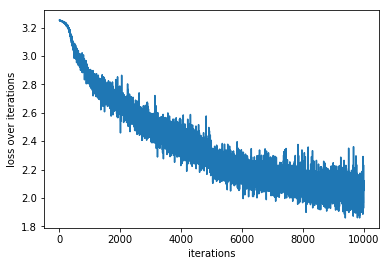

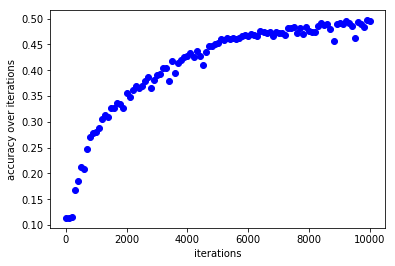

plotting ended
----------------------------
evaluation started
The accuracy over test dataset is 0.5019


In [5]:
layer_dimensions = [3072, 1000, 500, 100, 10]  # including the input and output layers  
# 3072 is the input feature size, 10 is the number of outputs in the final layer
FCN = FullyConnectedNetwork(layer_dimensions)
FCN.train(X_train, Y_train, max_iters=10000, batch_size=500, learning_rate=0.001, validate_every=100)
# lambd, the L2 regularization penalty hyperparamter will be 0 for this part
acc = FCN.evaluate(X_test, Y_test)  # print accuracy on test set
print("The accuracy over test dataset is", acc)

## Part 2

traning started
Step is: 0 | Loss is: 3.25768069456 | Accuracy is: 0.0907
Step is: 100 | Loss is: 3.25100556688 | Accuracy is: 0.1311
Step is: 200 | Loss is: 3.229868769 | Accuracy is: 0.1294
Step is: 300 | Loss is: 3.19277284314 | Accuracy is: 0.1574
Step is: 400 | Loss is: 3.11775628836 | Accuracy is: 0.1845
Step is: 500 | Loss is: 3.05489772918 | Accuracy is: 0.2182
Step is: 600 | Loss is: 2.99440792393 | Accuracy is: 0.2232
Step is: 700 | Loss is: 2.95070566598 | Accuracy is: 0.2437
Step is: 800 | Loss is: 2.95703012409 | Accuracy is: 0.2633
Step is: 900 | Loss is: 2.88726143409 | Accuracy is: 0.2801
Step is: 1000 | Loss is: 2.91068662691 | Accuracy is: 0.2878
Step is: 1100 | Loss is: 2.79883592684 | Accuracy is: 0.2973
Step is: 1200 | Loss is: 2.78307650221 | Accuracy is: 0.31
Step is: 1300 | Loss is: 2.78514574335 | Accuracy is: 0.3137
Step is: 1400 | Loss is: 2.83161447844 | Accuracy is: 0.3189
Step is: 1500 | Loss is: 2.78080465103 | Accuracy is: 0.3237
Step is: 1600 | Loss is:

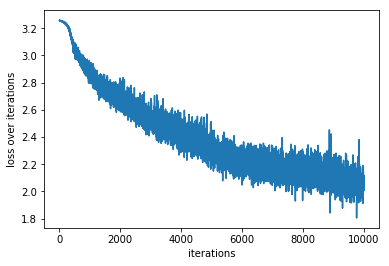

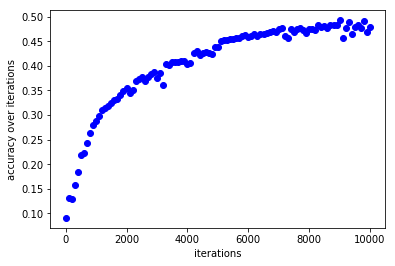

plotting ended
----------------------------
evaluation started
The accuracy over test dataset is 0.4827


In [6]:
layer_dimensions = [3072, 1000, 500, 100, 10]  # including the input and output layers  
# 3072 is the input feature size, 10 is the number of outputs in the final layer
FCN = FullyConnectedNetwork(layer_dimensions, lambd=0.0001)
FCN.train(X_train, Y_train, max_iters=10000, batch_size=500, learning_rate=0.001, validate_every=100)
# lambd, the L2 regularization penalty hyperparamter will not be 0 for this part
y_predicted = FCN.evaluate(X_test, Y_test)  # print accuracy on test set
print("The accuracy over test dataset is", y_predicted)

## Extra Credit